# Mimetic Finite Difference Method for Fluid Simulation

In this notebook we discretize and solve the fluid equations in 2D, to demonstrate the Mimetic Finite Difference (MFD) method.
We will consider the incomressible Euler equations:

$$ \begin{align*}
\nabla \cdot \vec{u} &= 0 \\
\frac{\partial \vec{u}}{\partial t} + \vec{u} \cdot \nabla \vec{u} + \frac{1}{\rho}\nabla p &= \vec{f}
\end{align*} $$
where $\vec{u}$ is the velocity field, $p$ is the pressure driving the internal source term $\nabla p$, and $\vec{f}$ is the external source term representing external forces. These equations are solved on a domain $\Omega \subset \mathbb{R}^2$.

The velocity is first advected by solving 
$\partial \vec{u}/\partial t + \vec{u} \cdot \nabla \vec{u} = 0$ on a divergence-free velocity field. The external forces $\vec{f}$ are then applied to the resulting velocity field. Finally the velocity is corrected to be divergence-free using the incomressibility equations 
$$ \begin{align}
\nabla \cdot \vec{u} &= 0 \\
\frac{\partial \vec{u}}{\partial t} + \frac{1}{\rho}\nabla p &= 0
\end{align} $$

The MFD method is used to solve for incompressibility of the velocity field. In the following sections, we shall denote the advected velocity by $\vec{u}^*$ and assume that $\vec{f} = \vec{0}$ unless otherwise stated. The second incompressibility equation is discretized in time using a forward Euler scheme thus reducing the above equations to
$$ \begin{align*}
\nabla \cdot \vec{u} &= 0 \\
\vec{u} &= \vec{u}^* - \Delta t \nabla p
\end{align*} $$
where we have taken $\rho = 1$ for simplicity. We can now eliminate the velocity unknown, further simplifying the equation to
$$ \Delta t \nabla \cdot \nabla p = \nabla \cdot \vec{u}^*, $$
which is precisely the euqation we will focus on.

A critical part of the method is enforcing boundary conditions. In general the above equations are subject to Dirichlet and Neumann boundary conditions:
$$ \begin{align*}
p &= f^D \text{ on } \Gamma^D \\
\vec{n} \cdot \vec{u} &= f^N \text{ on } \Gamma^N
\end{align*} $$
where $\Gamma^D$ and $\Gamma^N$ are parts of the boundary on which Dirichlet and Neumann boundary conditions are enforced respectively, and $\vec{n}$ is the outward facing normal to the domain boundary $\partial \Omega = \Gamma^D \cup \Gamma^N$.

## The MFD method on a regular grid

First, we discretize a standard square grid on the domain $\Omega = [-1,1] \times [-1,1] \subset \mathbb{R}^2$. Pressures are stored on grid nodes, and velocities are broken into the horizontal and vertical components along grid lines, sampled midway into a cell face/edge. In some sense this discretization is dual to the standard MAC grid.

The pressure degrees of freedom on the grid are denoted by $p_i = p(\vec{x}_i)$ for each node $i$ at position $\vec{x}_i$. The vector describing these pressure values at all nodes is denoted by $\mathbf{p} = (p_i)_i$.

Velocities are sampled on edge midpoints as $u_e = \frac{1}{\left|\vec{x}_j - \vec{x}_i\right|}\int_e \vec{u}\cdot d\hat{\tau}$ for each edge $e = (\vec{x}_i, \vec{x}_j)$, where $\hat{\tau}$ is the tangential unit vector. The vector describing these velocity values at all edges on the discrete mesh is denoted by $\mathbf{u} = (u_e)_e$.

Let $N_V$ denote the number of nodes and $N_E$, the number of edges on the grid. In fact on a grid of $n\times n$ nodes, $N_V = n^2$ and $N_E = 2n(n-1)$. Also note that $\mathbf{p} \in \mathbb{R}^{N_V}$ and $\mathbf{u} \in \mathbb{R}^{N_E}$.

<img src="grid-sample.svg" style="width: 8em; height 8em; display: inline; float: right; margin: 0.5em">

Note that the horizontal and vertical edges on the grid mesh are chosen to point right and up respectively. The figure on the right gives an example of a $3\times3$ node grid where the <font color="0000bf"><b>pressures</b></font> are stored at the nodes (in <font color="0000bf"><b>blue</b></font>), and <font color="bf0000"><b>velocities</b></font> are stored at the edge midpoints (in <font color="bf0000"><b>red</b></font>).

We define a gradient operator $\mathbf{G} : \mathbb{R}^{N_V} \to \mathbb{R}^{N_E}$ on the mesh by
$$ (\mathbf{G} \mathbf{p})_e = \frac{p_j - p_i}{\left|\vec{x}_j - \vec{x}_i\right|}. $$
Using the MFD technology we can also define a corresponding discrete divergence operator as the dual of the given gradient operator:
$$ \mathbf{D} \equiv - \mathbf{M}_V^{-1} \mathbf{G}^T \mathbf{M}_E, $$
where $\mathbf{M}_V$ and $\mathbf{M}_E$ are the inner product matrices (i.e. symmteric positive definite). These matrices define the unique inner products on $\mathbb{R}^{N_V}$ and $\mathbb{R}^{N_E}$ as follows

$$
\begin{align*}
\langle\mathbf{q}, \mathbf{r}\rangle_V &\equiv \mathbf{q}^T\mathbf{M}_V\mathbf{r} 
&& \forall \mathbf{q}, \mathbf{r} \in \mathbb{R}^{N_V}\\
\langle\mathbf{v}, \mathbf{w}\rangle_E &\equiv \mathbf{v}^T\mathbf{M}_E\mathbf{w}
&& \forall \mathbf{v}, \mathbf{w} \in \mathbb{R}^{N_E}.
\end{align*}
$$

The duality between $\mathbf{G}$ and $\mathbf{D}$ is illustrated by the following relationship 
$$ 
\langle\mathbf{G}\mathbf{q}, \mathbf{v}\rangle_E = -\langle\mathbf{q}, \mathbf{D}\mathbf{v}\rangle_V
$$

This formulation allows us to discretize the PDE as $\Delta t \mathbf{D}\mathbf{G}\mathbf{p} = \mathbf{D}\mathbf{u}^*$, which becomes
$$
\Delta t \mathbf{G}^T\mathbf{M}_E\mathbf{G}\mathbf{p} = \mathbf{G}^T\mathbf{M}_E\mathbf{u}^*
$$

In our tests we will assume, for simplicity, that $\Delta t = 1$. Furthermore, since we are only concerned with the edge based inner product, the subscript $E$ can be dropped, leaving us with the simple symmetric positive semi-definite system
$$\mathbf{G}^T \mathbf{M} \mathbf{G}\mathbf{p} = \mathbf{G}^T \mathbf{M} \mathbf{u}^*$$
where $\mathbf{p}$ is the unknown pressure and $\mathbf{u}^*$ is the input velocity field.

### Building the mass matrix $\mathbf{M}$

We assemble the matrix $\mathbf{M}$ on a per-cell basis mimicking the additivity of the continuous inner product:
$$ \langle \mathbf{u}, \mathbf{v} \rangle = \sum_c \langle \mathbf{u}_c,\mathbf{v}_c \rangle_c = \sum_c \mathbf{u}_c^T \mathbf{M}_c \mathbf{v}_c \forall \mathbf{u}, \mathbf{v} \in \mathbb{R}^{N_E}$$
where $\mathbf{u}_c$ and $\mathbf{v}_c$ are the vectors $\mathbf{u}$ and $\mathbf{v}$ restricted to the edges of cell $c$, and $\mathbf{M}_c$ is the corresponding cell-based inner product matrix.

The MFD framework provides second order convergence of the pressure (wrt. grid resolution) under the following condition:

<b>Consistency:</b> For any two vector fields $\vec{u}$ and $\vec{v}$ restricted to the cell $c$ and discretized by $\mathbf{u}_c$ and $\mathbf{v}_c$ on the edges of $c$ respectively, we have that
$$\langle \mathbf{u}_c,\mathbf{v}_c \rangle_c = \int_c \vec{u} \cdot \vec{v}\, dV$$
if $\vec{v}$ and $\nabla \times \vec{u}$ are constant and $\vec{u} \cdot \hat{\tau}_e$ is constant for each edge $e \in\partial c$.

Thus we would like to build a matrix $\mathbf{M}_c$ such that it satisfies the consistency condition.

Note that since $\vec{v}$ is constant, we can express it as
$$\vec{v} = v_x \hat{e}_1 + v_y \hat{e}_2$$
where $\{\hat{e}_1, \hat{e}_2\}$ is a canonical basis of $\mathbb{R}^2$, and $v_x,v_y\in\mathbb{R}$ are constants.
Then let $\vec{q}_1 \equiv (y - y_c)\hat{e}_3$ and $\vec{q}_2 \equiv (x_c-x)\hat{e}_3$ where $(x_c,y_c)$ is the centroid of cell $c$ and $\hat{e}_3$ supplements our basis to span $\mathbb{R}^3$. Note that $\hat{e} = \nabla \times \vec{q}_i$ for $i = 1,2$, so we can write
$$\vec{v} = v_x \nabla \times \vec{q}_1 + v_y \nabla \times \vec{q}_2 = \nabla \times (v_x\vec{q}_1 + v_y\vec{q}_2).$$
Now let $\vec{q} \equiv v_x\vec{q}_1 + v_y\vec{q}_2 = q_z\hat{e}_3$, where $q_z = v_x(y-y_c) + v_y(x_c-x)$. Then observe that
$$
\begin{align*}
\int_c \vec{u} \cdot \vec{v}\, dV &= \int_c \vec{u} \cdot \nabla \times \vec{q}\, dV \\
&= \int_c \vec{q} \cdot \nabla \times \vec{u} dV + \int_c \nabla \cdot (\vec{q} \times \vec{u})\, dV \\
\end{align*}
$$
where the first term is identically zero since $\nabla \times \vec{u}$ is constant and $\int_c \vec{q} dV = 0$. This further reduces to
$$
\begin{align*}
&= \int_c \nabla \cdot (\vec{q} \times \vec{u})\, dV \\
&= \int_{\partial c} (\vec{q} \times \vec{u}) \cdot \hat{n}\, dL && \text{ by divergence theorem } \\
&= -\sum_{e\in\partial c}\int_{e} \vec{u} \cdot (\vec{q} \times \hat{n}_{c,e})\, dL \\
&= -\sum_{e\in\partial c}\int_{e} \vec{u} \cdot \alpha_e q_z \hat{\tau}_e\, dL.
\end{align*}
$$
The last step follows from the relationship between the edge normal and our fixed edge directions to be $\alpha_e \hat{\tau}_e = \hat{e}_3 \times \hat{n}_{c,e}$ where $\alpha_e \in \{-1,1\}$ is determined by the orientation of the outward facing normal $\hat{n}_{c,e}$ and the fixed edge direction $\hat{\tau}_e$. Finally since $\vec{u} \cdot \hat{\tau}_e$ is constant on each edge, we can write
$$\int_c \vec{u} \cdot \vec{v}\, dV  = -\sum_{e\in\partial c} \alpha_e \vec{u} \cdot \hat{\tau}_e \int_e q_z\, dL = -\sum_{e\in\partial c} \alpha_e u_e \int_e q_z\, dL. $$
Thus it suffices to find $\mathbf{M}_c$ such that
$$ \mathbf{u}_c^T \mathbf{M}_c \mathbf{v}_c = -\sum_{e\in\partial c} \alpha_e u_e \int_e q_z\, dL $$
in order to satisfy the consistency condition. Note that $\mathbf{u}$ can be any vector in $\mathbb{R}^{N_E}$ since we can always find a $\vec{u}$ such that
$$ \nabla \times \vec{u} = \frac{1}{|c|}\sum_{e\in\partial c} \alpha_e |e| u_e $$
in $c$ subject to boundary conditions $ \hat{\tau}_e \cdot \vec{u} = \alpha_e u_e $ for all $e \in \partial c$.

In [2]:
# Define a function to sample given pressure, input and output velocity test functions given some grid size
function init(dx, pres, in_vel, out_vel)
    xs = [-1:dx:1];
    n = length(xs);
    
    apply(f, A) = (i,j) -> A[i,j] = f(xs[i], xs[j]);
    apply_with_off(f, A, off, k) = (i,j) -> A[i,j] = f(xs[i]+off[1], xs[j]+off[2])[k];

    pmtx = Array(Float64, (n,n)); # nodal pressure matrix
    cartesianmap(apply(pres, pmtx), size(pmtx));

    # Define a mac-like grid
    uvin = Array(Float64, (n,n-1)); # vertical velocity matrix
    cartesianmap(apply_with_off(in_vel, uvin, [0,dx/2], 2), size(uvin));

    uhin = Array(Float64, (n-1,n)); # horizontal velocity matrix
    cartesianmap(apply_with_off(in_vel, uhin, [dx/2,0], 1), size(uhin));

    # Also sample the solution
    uvout = Array(Float64, (n,n-1)); # vertical velocity matrix
    cartesianmap(apply_with_off(out_vel, uvout, [0,dx/2], 2), size(uvout));

    uhout = Array(Float64, (n-1,n)); # horizontal velocity matrix
    cartesianmap(apply_with_off(out_vel, uhout, [dx/2,0], 1), size(uhout));

    # assemble system vectors
    p = pmtx[:];
    u = [uhin[:]; uvin[:]];
    u_sol = [uhout[:]; uvout[:]];

    return xs, p, u, u_sol
end;

## Dirichlet Boundary Conditions
### Example 1

In [3]:
# pressure solution
pressure(x, y) = x.*x + y.*y - 1;

# initial conditions
input_velocity(x, y) = [2*x*y + 2*x, -y*y + 2*y];

# final velocity solution
output_velocity(x, y) = [2*x*y, -y*y];

dx = 0.05;

xs, p, u, u_sol = init(dx, pressure, input_velocity, output_velocity)
n = length(xs); # number of nodes on each axis
    
# system dimensions
nn = n*n; # number of nodes
nhe = n*(n-1); # number of horizontal edges
nve = nhe;     # number of vertical edges
ne = nhe + nve; # total number of edges

3280

#### The known pressure solution

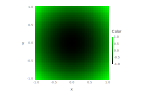

In [4]:
using Color, Gadfly
xmin = repeat(xs-dx/2, inner=[n]);
xmax = repeat(xs+dx/2, inner=[n]);
ymin = repeat(xs-dx/2, outer=[n]);
ymax = repeat(xs+dx/2, outer=[n]);
plot(x_min=xmin, x_max=xmax, y_min=ymin, y_max=ymax, color=p,
     Scale.y_continuous(minvalue=-1, maxvalue=1),
     Scale.x_continuous(minvalue=-1, maxvalue=1),
     Guide.xlabel("x"), Guide.ylabel("y"),
     Coord.cartesian(aspect_ratio=1.0),
     Geom.rectbin, Scale.ContinuousColorScale(c -> RGB(0,c,0)))

In [5]:
# Assemble the Gradient as applied to p (column-wise flattened pressure matrix)
# block giving a column of m-1 horizontal velocities from a column of m pressures
Gx(m) = ([zeros(m-1,1) eye(m-1)] - [eye(m-1) zeros(m-1,1)])/dx;
Gxs = kron(eye(n), Gx(n));

# block giving a row of m-1 vertical velocities from a row of m pressures
Gys = kron(Gx(n), eye(n));

In [13]:
# At this point we decide how our edges will be ordered in the matrix equations.
# We choose the horizontal edges uhin[:] followed by vertical edges uvin[:]
# Full gradient operator:
G = [Gxs; Gys];

In [7]:
assert(norm(u_sol - u + G*p) < 0.0001); #verify that the gradient operator is correct

It remains to find the mass matrix $\mathbf{M}$, which is assembled per cell within the mimetic framework as follows:
$$ \begin{align*}
\mathbf{M}^0_c &= \mathbf{R}_c (\mathbf{R}_c^T \mathbf{N}_c)^{-1}\mathbf{R}_c^T \\
\mathbf{M}^1_c &= \lambda\left(\mathbf{I} - \mathbf{N}_c(\mathbf{N}_c^T\mathbf{N}_c)^{-1}\mathbf{N}_c^T\right) \\
\lambda &= \frac{1}{2}\mathrm{Tr}\left(\mathbf{M}^0_c\right) \\
\mathbf{M}_c &= \mathbf{M}^0_c + \mathbf{M}^1_c
\end{align*}$$
Where in the case of our node-edge discretization, the matrices $\mathbf{R}_c=(\vec{R}_e)_e$ and $\mathbf{N}_c=(\vec{N}_e)_e$ are defined as
$$ \begin{align*}
\vec{R}_e &= \|\vec{x}_j - \vec{x}_i\|\left[y_e - y_c, x_c - x_e\right] \\
\vec{N}_e &= \frac{\vec{x}_j - \vec{x}_i}{\|\vec{x}_j - \vec{x}_i\|}
\end{align*}$$
where $\vec{x}_c = (x_c, y_c)$ is the centroid of a cell and $\vec{x}_e = (x_e, y_e)$ is the midpoint of an edge.

In [8]:
# Assemble the matrices R and N, and use them to compute M.
# iterate over each cell
M = zeros(ne,ne); # edge based mass matrix
for i = 1:(n-1)
    for j = 1:(n-1)
        c = dx*([i, j] - 0.5);
        le = [dx*(i-1),c[2]];
        be = [c[1], dx*(j-1)];
        re = [dx*i,c[2]];
        te = [c[1], dx*j];
        # construct in the order left -> bottom -> right -> top
        R = dx*[0 dx/2;  # left
             dx/2 0;  # bottom
             0 dx/2;  # right
             dx/2 0]; # top
        
        N = [0 1;  # left
             1 0;  # bottom
             0 1;  # right
             1 0]; # top
        M0 = R*inv(R'*N)*R';
        lambda = trace(M0)/2;
        M1 = lambda*(eye(4)-N*inv(N'*N)*N');
        Mc = M0 + M1;
        li = nhe + i + n*(j-1); # left index
        bi = i + (n-1)*(j-1); # bottom index
        ri = nhe + (i+1) + n*(j-1); # right index
        ti = i + (n-1)*j; # top index
        idx = [li, bi, ri, ti];
        for a = 1:4
            for b = 1:4
                M[idx[a], idx[b]] += Mc[a, b];
            end
        end
    end
end

In [9]:
A = zeros(nn,nn); # edge based semi-inner product matrix
for i = 1:(n-1)
    for j = 1:(n-1)
        # construct in the order bottom-left -> bottom-right -> top-right -> top-left
        bl = dx*[i-1 j-1];
        br = dx*[i j-1];
        tr = dx*[i j];
        tl = dx*[i-1 j];
        R = (dx/2)*[0 -1 -1; 0  1 -1; 0  1  1; 0 -1  1];
        
        N = [1 -dx/2 -dx/2; 1  dx/2 -dx/2; 1  dx/2  dx/2; 1 -dx/2  dx/2];
       # N = [1 bl; 1 br; 1 tr; 1 tl];
        
        invRtN = [0 0 0;
                  0 1 0;
                  0 0 1]/(dx*dx);
        M0 = R*invRtN*R';
        
        lambda = trace(M0);
        M1 = lambda*(eye(4)-N*inv(N'*N)*N');
        Mc = M0 + M1;
        
        # indices into main matrix A
        bli = i + n*(j-1);
        bri = i+1 + n*(j-1);
        tri = i+1 + n*j;
        tli = i + n*j;
        
        idx = [bli, bri, tri, tli];
        for a = 1:4
            for b = 1:4
                A[idx[a], idx[b]] += Mc[a, b];
            end
        end
    end
end

In [10]:
GtMG = G'*M*G;

In [11]:
assert(norm(GtMG - A) < 0.0001);

In [12]:
# define a function to force Dirichlet boundary conditions
function force_dirichlet(A, rhs, p, n)
    nn = n*n;
    # get boundary node indices
    bottom = [1:n];
    top = bottom + nn - n;
    left = bottom[2:n-1]*n - n + 1;
    right = left + n - 1;
    bdry = [bottom, left, right, top];

    # enforce dirichlet boundary conditions
    for v in bdry
        rhs[v] = p[v];
        for i = 1:n*n
            if i == v
                A[i,v] = 1;
            else
                rhs[i] -= A[i,v]*p[v];
                A[i,v] = 0;
                A[v,i] = 0;
            end
        end
    end
end

# Assemble the linear system

GTM1 = transpose(G'\A');
rhs1 = GTM1*u;
GTM2 = G'*M;
rhs2 = GTM2*u;
force_dirichlet(A, rhs1, p, n);
force_dirichlet(GtMG, rhs2, p, n);

p_new = A\rhs1;
println(norm(p-p_new));
println(norm(p-GtMG\rhs2));

2.794164142629542e-13
8.9208588363363e-14
